In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import os
from datetime import date, datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
sns.set()
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize
from pandas_profiling import ProfileReport
import statistics

In [3]:
#imports dataset
df = pd.read_csv(r'donors.csv')
#Pop_census2010=pd.read_csv(r'POP_census_2010.csv', sep=';')

In [4]:
#see head chunck of dataset
df.head()

,Unnamed: 0,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,...,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,0,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,...,7.741935,95515,0,L,4,E,X,X,X,C
1,1,2014-01-01,BOA,1,CA,91326,,,1972-02-01,0,...,15.666667,148535,0,L,2,G,X,X,X,A
2,2,2010-01-01,AMH,1,NC,27017,,,NaN,0,...,7.481481,15078,1,L,4,E,X,X,X,C
3,3,2007-01-01,BRY,0,CA,95953,,,1948-01-01,0,...,6.812500,172556,1,L,4,E,X,X,X,C
4,4,2006-01-01,,0,FL,33176,,,1940-01-01,0,...,6.864865,7112,1,L,2,F,X,X,X,A


In [5]:
#setscontrolN as index for easy donor ID
df = df.set_index('CONTROLN', drop = True).sort_index(axis = 0)

# DATA CLEANING & EXPLORATION

The dataset has, in total, 474 variables. As a way of exploring and cleaning the data more easily, we will here follow the approach of dividing the dataset in logical parts (see metadata file for additional info.):

**1) Personal / Demografic Info.**
    (variables ODATEDW to HIT + DATASRCE to GEOCODE + HPHONE_D + GEOCODE2)

**2) Personal preferences / interests** (variables MBCRAFT to PUBOPP + COLLECT1 to LIFESRC)

**3) Promotion / Giving history file** (ADATA_2 to AVGGIFT + RFA_2R to MDMAUD_A + PEP Star RFA Status)

**4) Neighborhood information - Data from Census** (POP901 to AC2)

# 1) Personal / Demografic Info.

In [6]:
#gets variables corresponding to personal / Demographic Data
df_personal = df[list(df.loc[:,'ODATEDW' : 'HIT']) + list(df.loc[:,'DATASRCE':'GEOCODE']) + list(['HPHONE_D']) + list(['GEOCODE2'])]

#checks varaibles
df_personal.columns

Index(['ODATEDW', 'OSOURCE', 'TCODE', 'STATE', 'ZIP', 'MAILCODE', 'PVASTATE',
       'DOB', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP', 'MDMAUD',
       'DOMAIN', 'HOMEOWNR', 'CHILD03', 'CHILD07', 'CHILD12', 'CHILD18',
       'NUMCHLD', 'INCOME', 'GENDER', 'WEALTH1', 'HIT', 'DATASRCE', 'MALEMILI',
       'MALEVET', 'VIETVETS', 'WWIIVETS', 'LOCALGOV', 'STATEGOV', 'FEDGOV',
       'SOLP3', 'SOLIH', 'MAJOR', 'WEALTH2', 'GEOCODE', 'HPHONE_D',
       'GEOCODE2'],
      dtype='object')

In [7]:
df_personal.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,LOCALGOV,STATEGOV,FEDGOV,SOLP3,SOLIH,MAJOR,WEALTH2,GEOCODE,HPHONE_D,GEOCODE2
CONTROLN,,,,,,,,,,,,,,,,,,,,,
1,2010-01-01,,1,TX,77096,,,1935-09-01,0,,...,0,0,0,12,,,9.0,05,0,A
2,2010-01-01,,0,CA,91320,,,1946-09-01,0,,...,0,0,0,,,,6.0,,0,A
4,2010-01-01,,1,KY,42701,,,1978-05-01,0,,...,0,0,0,,,,8.0,12,1,C
5,2009-01-01,,0,IN,47240,B,,1930-01-01,0,,...,0,0,0,12,,,NaN,,0,D
7,2007-01-01,ASC,0,MN,55102,B,,NaN,0,,...,0,0,0,,,,9.0,,0,A


Based on the metadata documentation, we will start by dropping the following variables: OSOURCE, TCODE, NOEXCH, RECINHSE, RECP3, RECPGVG, RECSWEEP, DATASRCE. These correspond to titles, in house flags, origin of data or other information not necessary and/or not fit for clustering analysis, thus clearly not bringing us any useful information for the goals of the study. Please note that these variables may or may not be recovered later on, for further goals of the study.

In [8]:
df_personal.drop(['OSOURCE', 'TCODE', 'MAILCODE', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP', 'DATASRCE'], axis = 1, inplace = True)

In [9]:
df['IC5']

CONTROLN
1         21409
2         15932
4         14337
5         11855
7         27371
          ...  
191772    16833
191775    22294
191777    21284
191778    10957
191779    35544
Name: IC5, Length: 95412, dtype: int64

Variables MDMAUD and MAJOR are redundant; we can easily filter this information drom variables that will be further explored; furthermore, they have no interest for cluster analysis. Thus, we will dropped them here.

In [10]:
df_personal.drop(['MDMAUD', 'MAJOR'], axis = 1, inplace = True)

In [11]:
#checks data info
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95412 entries, 1 to 191779
Data columns (total 29 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ODATEDW   95412 non-null  object 
 1   STATE     95412 non-null  object 
 2   ZIP       95412 non-null  object 
 3   PVASTATE  95412 non-null  object 
 4   DOB       71529 non-null  object 
 5   DOMAIN    95412 non-null  object 
 6   HOMEOWNR  95412 non-null  object 
 7   CHILD03   95412 non-null  object 
 8   CHILD07   95412 non-null  object 
 9   CHILD12   95412 non-null  object 
 10  CHILD18   95412 non-null  object 
 11  NUMCHLD   12386 non-null  float64
 12  INCOME    74126 non-null  float64
 13  GENDER    95412 non-null  object 
 14  WEALTH1   50680 non-null  float64
 15  HIT       95412 non-null  int64  
 16  MALEMILI  95412 non-null  int64  
 17  MALEVET   95412 non-null  int64  
 18  VIETVETS  95412 non-null  int64  
 19  WWIIVETS  95412 non-null  int64  
 20  LOCALGOV  95412 non-null  i

In [12]:
#converts type of ODATEDW instances to datetime
df_personal['ODATEDW'] = pd.to_datetime(df_personal['ODATEDW'])
df['ADATE_2'] = pd.to_datetime(df['ADATE_2'])


#calculates longevity of donors in PVA using the date of the first gift and current date (XX-12-2020)
df_personal['LONGEVITY'] = (df['ADATE_2'].dt.year - df_personal['ODATEDW'].dt.year)*12 + ((df['ADATE_2'].dt.month - df_personal['ODATEDW'].dt.month))

#drops variable ODATEDW as this will no longer neede since we have the #years the donors are associated to PVA
df_personal.drop(['ODATEDW'], axis = 1, inplace = True)

In [13]:
#converts type of DOB instances to datetime
df_personal['DOB'] = pd.to_datetime(df_personal['DOB'])
df['ADATE_2'] = pd.to_datetime(df['ADATE_2'])


#calculates age of donors using their date of birthd and current date (XX-12-2020)
df_personal['AGE'] = (df['ADATE_2'].dt.year - df_personal['DOB'].dt.year) - ((df['ADATE_2'].dt.month - df_personal['DOB'].dt.month) < 0)

#drops variable DOB as this will no longer neede since we have the age of the donors
df_personal.drop(['DOB'], axis = 1, inplace = True)

In [14]:
#checks descriptive statistics
df_personal.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
STATE,95412,57,CA,17343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZIP,95412,19938,85351,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PVASTATE,95412,3,,93954,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DOMAIN,95412,17,R2,13623,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOMEOWNR,95412,3,H,52354,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHILD03,95412,4,,94266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHILD07,95412,4,,93846,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHILD12,95412,4,,93601,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHILD18,95412,4,,92565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NUMCHLD,12386,NaN,NaN,NaN,1.52777,0.806861,1,1,1,2,7


Variables CHILD03, CHILD07, CHILD12, CHILD18, NUMCHILD and GEOCODE have a high value of missing values (>80%); furthermore, we have no information in the metadata saying whether blank values correspond to nulls or correspond to missing data. For these reasons, they will be dropped.

Variables SOLP3 and SOLIH won't be useful for clustering purposes, they'll be dropped here.

In [15]:
df_personal.drop(['CHILD03', 'CHILD07', 'CHILD12', 'CHILD18', 'NUMCHLD', 'GEOCODE', 'SOLP3', 'SOLIH'], axis = 1, inplace = True)

We have three variables - WEATH1, WEATHE2 and INCOME - related to socioeconomic status. We checked correlations between the three of them and WEALTH1 and WEALTH2 are very highly correlated. Thus, WEALTH1 will be droped as it has a higher number of missing values than WEALTH2. (Household) INCOME will be kept as it wasn't strongly correlated with WEALTH and these variables can give us different information.

In [16]:
print(df_personal['WEALTH1'].corr(df_personal['WEALTH2']))
print(df_personal['WEALTH1'].corr(df_personal['INCOME']))
print(df_personal['WEALTH2'].corr(df_personal['INCOME']))

#replaces nans in WEALTH1 with value in WEALTH2
df_personal.WEALTH1.fillna(df.WEALTH2, inplace=True)

#drops WEALTH2
df_personal.drop(['WEALTH2'], axis = 1, inplace = True)

#renames column WEALTH1 to WEALTH
df_personal.rename(columns={"WEALTH1": "WEALTH"}, inplace = True)


0.8694309487310721
0.4560944638532512
0.4053983811344813


DEALING WITH MISSING VALUES & some CLEANING

In [17]:
#in the rest of variables missing values can be converted to NaN
df_personal.replace(" ", np.nan, inplace=True)


In [18]:
#count of missing values
df_personal.isna().sum()

STATE            0
ZIP              0
PVASTATE     93954
DOMAIN        2316
HOMEOWNR     22228
INCOME       21286
GENDER        2957
WEALTH       21843
HIT              0
MALEMILI         0
MALEVET          0
VIETVETS         0
WWIIVETS         0
LOCALGOV         0
STATEGOV         0
FEDGOV           0
HPHONE_D         0
GEOCODE2       319
LONGEVITY        0
AGE          23883
dtype: int64

In [19]:
#deals with ' ' spaces and converts appropriate variables to dummies

df_personal.drop(['PVASTATE', 'GEOCODE2', 'DOMAIN', 'HPHONE_D'], axis = 1, inplace = True) #based on: I affin want to. That or they useless.
df_personal['HOMEOWNR'].replace(["H", "U", " "], [1, 0, np.nan], inplace=True)
df_personal['GENDER'].replace(["M", "F", "U", "J", "A", "C"], [0, 1, np.nan, 2, np.nan, np.nan], inplace=True)



FILLING DOMAIN COM CLUSTERS WTV (WEALTH/INCOME??); WEALTH 2 as well; AGE AS WELL; WEALTH AS WELL, GENDER AS WELL, INCOME, HOMEOWNR

In [20]:
mode = df_personal['HOMEOWNR'].mode().loc[0]
df_personal['HOMEOWNR'] = df_personal['HOMEOWNR'].fillna(mode)
mode = df_personal['INCOME'].mode().loc[0]
df_personal['INCOME'] = df_personal['INCOME'].fillna(mode)
mode = df_personal['GENDER'].mode().loc[0]
df_personal['GENDER'] = df_personal['GENDER'].fillna(mode)
mode = df_personal['WEALTH'].mode().loc[0]
df_personal['WEALTH'] = df_personal['WEALTH'].fillna(mode)
mode = df_personal['AGE'].mode().loc[0]
df_personal['AGE'] = df_personal['AGE'].fillna(mode)
#median = statistics.median(df_personal['AGE'])
#df_personal['AGE'] = df_personal['AGE'].fillna(median)

In [21]:
df_personal.head()

,STATE,ZIP,HOMEOWNR,INCOME,GENDER,WEALTH,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,LONGEVITY,AGE
CONTROLN,,,,,,,,,,,,,,,,
1,TX,77096,1.0,4.0,0.0,9.0,19,0,0,0,0,0,0,0,89,81.0
2,CA,91320,1.0,7.0,1.0,6.0,2,0,0,0,0,0,0,0,89,70.0
4,KY,42701,1.0,5.0,0.0,9.0,12,0,0,0,0,0,0,0,89,39.0
5,IN,47240,1.0,2.0,0.0,9.0,0,0,0,0,0,0,0,0,101,87.0
7,MN,55102,1.0,1.0,1.0,9.0,3,0,0,0,0,0,0,0,125,49.0


ZIP variable's values need to be cleaned as some of them have a - at the end:

In [22]:
for i, value in zip(df_personal['ZIP'].index, df_personal['ZIP']):
    if value[-1] == '-':
        df_personal['ZIP'][i] = value[0:-1]

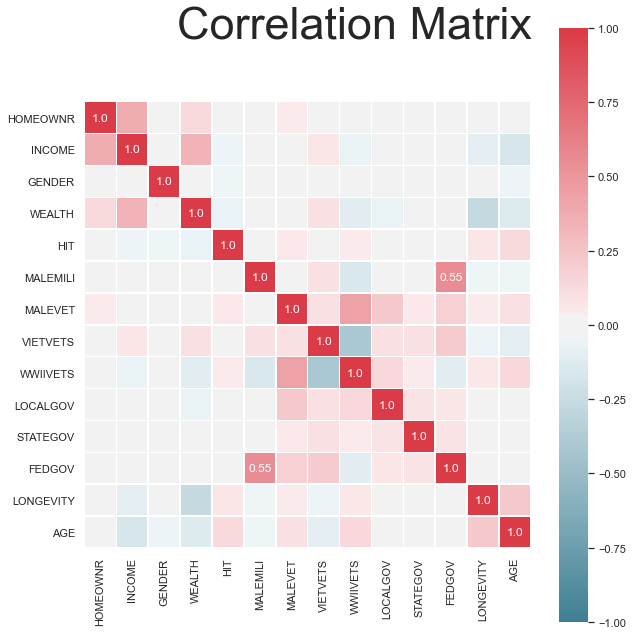

In [23]:
# Prepare figure
fig = plt.figure(figsize=(10, 10))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df_personal.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=45)

plt.show()

In [24]:
#FINAL DATASET TO USE: df_personal

metrics_personal = ['INCOME', 'WEALTH', 'MALEMILI', 'MALEVET', 'VIETVETS', 'WWIIVETS', 'LOCALGOV', 'STATEGOV', 'FEDGOV', 'LONGEVITY', 'AGE']


# 2) Personal Preferences / Interests

In [25]:
#gets variables corresponding to personal / Demographic Data
df_preferences = df[list(df.loc[:,'COLLECT1':'LIFESRC']) + list(df.loc[:,'MBCRAFT':'PUBOPP'])]

#checks varaibles
df_preferences.columns

Index(['COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS', 'CDPLAY',
       'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS',
       'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES', 'LIFESRC', 'MBCRAFT',
       'MBGARDEN', 'MBBOOKS', 'MBCOLECT', 'MAGFAML', 'MAGFEM', 'MAGMALE',
       'PUBGARDN', 'PUBCULIN', 'PUBHLTH', 'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO',
       'PUBOPP'],
      dtype='object')

In [26]:
df_preferences.head()

,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,...,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP
CONTROLN,,,,,,,,,,,,,,,,,,,,,
1,,,,,,,Y,Y,,,...,1.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0
2,,,,,,,,,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,,,,,,,,,,,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5,,,,,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,,,Y,,,,,,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#checks data info
df_preferences.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95412 entries, 1 to 191779
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   COLLECT1  95412 non-null  object 
 1   VETERANS  95412 non-null  object 
 2   BIBLE     95412 non-null  object 
 3   CATLG     95412 non-null  object 
 4   HOMEE     95412 non-null  object 
 5   PETS      95412 non-null  object 
 6   CDPLAY    95412 non-null  object 
 7   STEREO    95412 non-null  object 
 8   PCOWNERS  95412 non-null  object 
 9   PHOTO     95412 non-null  object 
 10  CRAFTS    95412 non-null  object 
 11  FISHER    95412 non-null  object 
 12  GARDENIN  95412 non-null  object 
 13  BOATS     95412 non-null  object 
 14  WALKER    95412 non-null  object 
 15  KIDSTUFF  95412 non-null  object 
 16  CARDS     95412 non-null  object 
 17  PLATES    95412 non-null  object 
 18  LIFESRC   95412 non-null  object 
 19  MBCRAFT   42558 non-null  float64
 20  MBGARDEN  42558 non-null  f

Variable LIFESRC indicates origin of data; useless. It'll be dropped.

In [28]:
df_preferences.drop(['LIFESRC'], axis = 1, inplace = True)

DEALING WITH MISSING VALUES

Missing values will be filled in with NaN and all instances will be converted to dummies.

In [29]:
#count of missing values
df_preferences.isna().sum()

COLLECT1        0
VETERANS        0
BIBLE           0
CATLG           0
HOMEE           0
PETS            0
CDPLAY          0
STEREO          0
PCOWNERS        0
PHOTO           0
CRAFTS          0
FISHER          0
GARDENIN        0
BOATS           0
WALKER          0
KIDSTUFF        0
CARDS           0
PLATES          0
MBCRAFT     52854
MBGARDEN    52854
MBBOOKS     52854
MBCOLECT    52914
MAGFAML     52854
MAGFEM      52854
MAGMALE     52854
PUBGARDN    52854
PUBCULIN    52854
PUBHLTH     52854
PUBDOITY    52854
PUBNEWFN    52854
PUBPHOTO    52854
PUBOPP      52854
dtype: int64

In [30]:
#deals with ' ' spaces and converts appropriate variables to dummies
df_preferences.replace([" ", 'Y', np.nan], [0, 1, 0], inplace=True)

In [31]:
#converts all dummies to type int
df_preferences = df_preferences.astype(int)

In [32]:
#confirms conversion
df_preferences.dtypes

COLLECT1    int64
VETERANS    int64
BIBLE       int64
CATLG       int64
HOMEE       int64
PETS        int64
CDPLAY      int64
STEREO      int64
PCOWNERS    int64
PHOTO       int64
CRAFTS      int64
FISHER      int64
GARDENIN    int64
BOATS       int64
WALKER      int64
KIDSTUFF    int64
CARDS       int64
PLATES      int64
MBCRAFT     int64
MBGARDEN    int64
MBBOOKS     int64
MBCOLECT    int64
MAGFAML     int64
MAGFEM      int64
MAGMALE     int64
PUBGARDN    int64
PUBCULIN    int64
PUBHLTH     int64
PUBDOITY    int64
PUBNEWFN    int64
PUBPHOTO    int64
PUBOPP      int64
dtype: object

In [33]:
#observe dataset
df_preferences.head()

,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,...,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP
CONTROLN,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,1,1,0,0,...,1,0,0,0,1,2,0,2,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,1,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


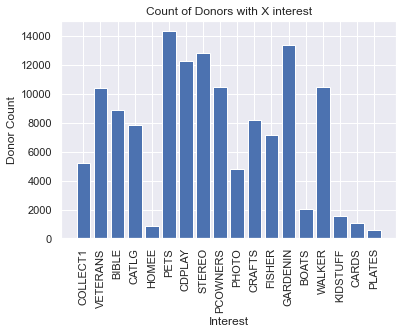

In [34]:
#Categorical/Low Cardinality variables
interests = df_preferences.loc[:,'COLLECT1':'PLATES']

#uses describe
describe = df_preferences.describe().T
values = [len(interests[interests[column] == 1]) for column in interests.columns]

#plotting
plt.bar(interests.columns, values)
plt.xticks(rotation=90)
plt.ylabel('Donor Count')
plt.xlabel('Interest')
plt.title('Count of Donors with X interest')
plt.show()

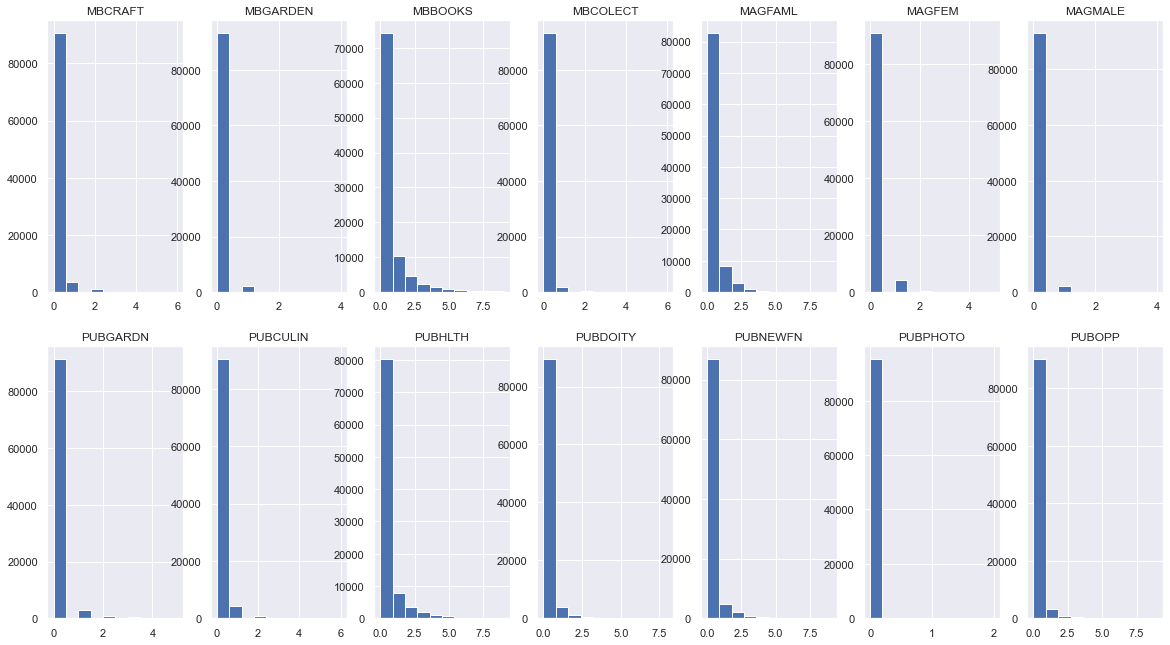

In [35]:
#Numeric variables
mail_responses = df_preferences.loc[:,'MBCRAFT':'PUBOPP']


#uses describe
describe = mail_responses.describe().T

#Plots
fig, axes = plt.subplots(2, ceil(mail_responses.shape[1] / 2), figsize=(20, 11))

for ax, feat in zip(axes.flatten(), mail_responses):
    ax.hist(mail_responses[feat])
    ax.set_title(feat)


plt.show()

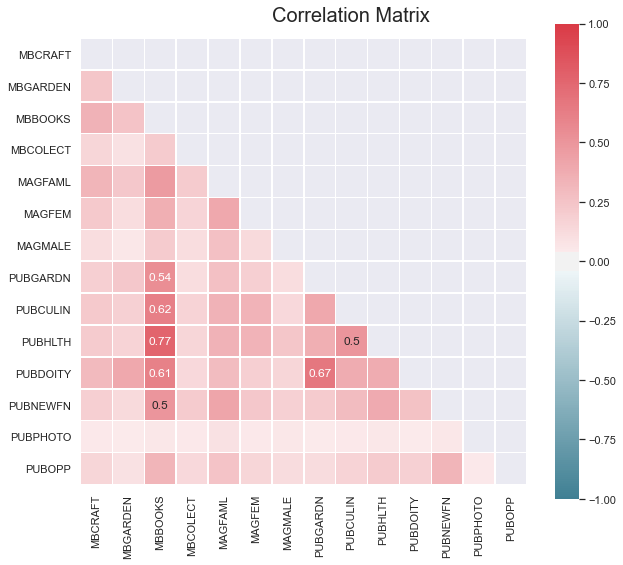

In [36]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(mail_responses.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5, mask=np.triu(np.ones_like(corr.corr())) )

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

Note: gender preferences were checked and no differences in correlations were found.

FINAL DATASET FOR FUTURE USE:

In [38]:
df_preferences = df_preferences.copy()

# 3) Promotion / Giving History File

We will be only be working with the summary variables of the promotion history file, as well as the summary variables from the giving history file (which have proven to be highly correlated among themselves).

In [39]:
#gets variables corresponding to personal / Demographic Data
df_history_file = df[list(df.loc[:,'CARDPROM' : 'NUMPRM12']) + list(df.loc[:,'RAMNTALL':'AVGGIFT']) + list(df.loc[:,'RFA_2R':'MDMAUD_A']) + list(['PEPSTRFL'])] 

#checks variables
df_history_file.columns

Index(['CARDPROM', 'MAXADATE', 'NUMPROM', 'CARDPM12', 'NUMPRM12', 'RAMNTALL',
       'NGIFTALL', 'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE',
       'LASTGIFT', 'LASTDATE', 'FISTDATE', 'NEXTDATE', 'TIMELAG', 'AVGGIFT',
       'RFA_2R', 'RFA_2F', 'RFA_2A', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A',
       'PEPSTRFL'],
      dtype='object')

In [40]:
df_history_file.head()

,CARDPROM,MAXADATE,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,...,NEXTDATE,TIMELAG,AVGGIFT,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,PEPSTRFL
CONTROLN,,,,,,,,,,,,,,,,,,,,,
1,23,2017-02-01,60,5,12,273.00,12,6,10.0,2015-09-01,...,2010-01-01,3.0,22.750000,L,3,F,X,X,X,X
2,36,2017-02-01,99,9,27,157.00,16,3,5.0,2012-04-01,...,2010-02-01,4.0,9.812500,L,1,F,X,X,X,
4,39,2017-02-01,97,10,22,209.00,14,5,5.0,2010-02-01,...,2010-01-01,3.0,14.928571,L,1,F,X,X,X,X
5,19,2017-02-01,45,5,12,297.00,35,7,5.0,2012-04-01,...,2009-10-01,0.0,8.485714,L,1,F,X,X,X,X
7,40,2017-02-01,117,6,22,716.25,68,19,3.0,2013-04-01,...,2007-06-01,4.0,10.533088,L,1,E,X,X,X,X


In [41]:
#we started by checking whether all donors classified as lapsed were actually lapsed donors, based on their last date of donation and date of last update of the system (= date of last promotion: ADATE_2)
df_history_file['LASTDATE'] = pd.to_datetime(df_history_file['LASTDATE'])

df_history_file['period'] = (df['ADATE_2'].dt.year - df_history_file['LASTDATE'].dt.year)*12 + ((df['ADATE_2'].dt.month - df_history_file['LASTDATE'].dt.month))



In [42]:
df_history_file = df_history_file[(df_history_file['period'] <= 24) & (df_history_file['period'] >= 13)]

In [43]:
print('Percentage of data kept after removing mislabled Lapsed Donors:', np.round(df_history_file.shape[0] / df.shape[0], 4)*100)


Percentage of data kept after removing mislabled Lapsed Donors: 88.18


In [44]:
#People who have only donated once will be removed! These are donors whose behavior we can't study.
#Donots whose TIMELAG or NEXTDATE variable = NaN will be removed as a consequence they haven't dontated twice.

df_history_file = df_history_file[df_history_file['NGIFTALL']!=1]


In [45]:
print('Percentage of data kept after removing one time donors:', np.round(df_history_file.shape[0] / 84132, 4)*100)
print('Percentage of data kept from total:', np.round(df_history_file.shape[0] / df.shape[0], 4)*100)


Percentage of data kept after removing one time donors: 88.3
Percentage of data kept from total: 77.86


In [46]:
#drops coz its 50:50 prop
df_history_file.drop('PEPSTRFL', axis = 1, inplace = True) 

In [47]:
df_history_file.isna().sum()

CARDPROM    0
MAXADATE    0
NUMPROM     0
CARDPM12    0
NUMPRM12    0
RAMNTALL    0
NGIFTALL    0
CARDGIFT    0
MINRAMNT    0
MINRDATE    0
MAXRAMNT    0
MAXRDATE    0
LASTGIFT    0
LASTDATE    0
FISTDATE    0
NEXTDATE    0
TIMELAG     0
AVGGIFT     0
RFA_2R      0
RFA_2F      0
RFA_2A      0
MDMAUD_R    0
MDMAUD_F    0
MDMAUD_A    0
period      0
dtype: int64

In [48]:
df_history_file['PROP_RESP_CARDPROM'] = df_history_file['CARDGIFT']/df_history_file['CARDPROM']


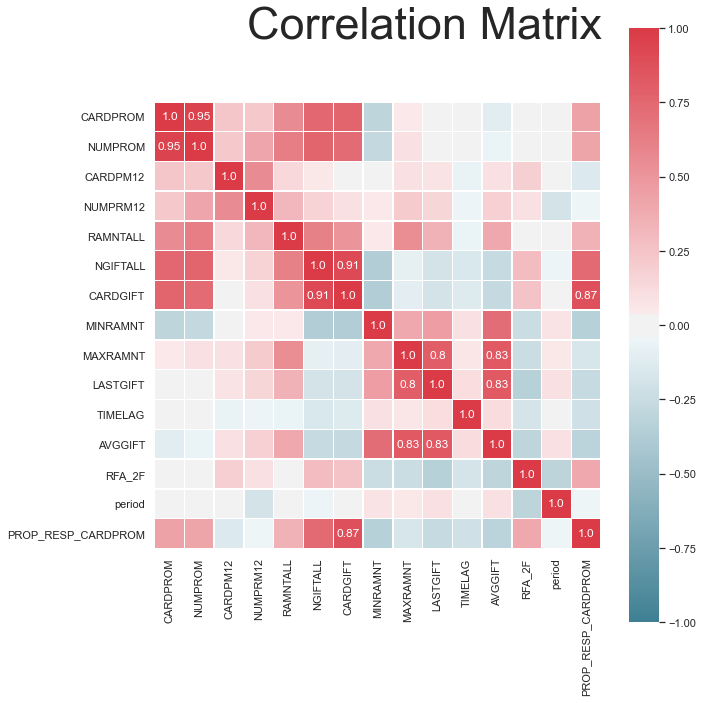

In [49]:
# Prepare figure
fig = plt.figure(figsize=(10, 10))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df_history_file.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.8
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=45)

plt.show()

Highly correlated variables - CARDPROM, CARDGIFT  -  will be dropped as they encode redundant info.

period, CARDPROM, MAXADATE, CARDPM12, NUMPRM12, CARDGIFT, MINRDATE, MINRAMNT, MAXRAMNT, MAXRDATE, LASTGIFT, LASTDATE, FISTDATE, NEXTDATE, TIMELAG will also be dropped, as the information encoded by these variables is either already encoded in other ones, or because they are not useful (anymore) for the purpose of the study:

- date of dirst gift should be already encoded in ODATEDW, which gives us when donors donated their first time, so FISTDATE will be dropped; NEXTDATE does not seem useful, as well as TIMELAG and dates associated with this - they were useful to calculate labels of donors tho!;

- CARDPRM12 and NUMPRM12 will also be dropped, as we don't know the difference between "card promotions" and "promotions" and they're highly correlated with total nr of promotions received.

- MDMAUD and RFA as well as we're clustering and this has no interest and/or are already indirectly encoded in other variables

- NUMPROM coz hiughly correlatede with NGIFTALL

In [50]:
df_history_file.drop(['period', 'NUMPROM', 'CARDPROM', 'MAXADATE', 'CARDPM12', 'NUMPRM12', 'CARDGIFT', 'MINRDATE', 'MINRAMNT', 'MAXRAMNT', 'MAXRDATE', 'LASTGIFT', 'LASTDATE', 'FISTDATE', 'NEXTDATE', 'TIMELAG', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A', 'RFA_2R', 'RFA_2A', 'RFA_2F'], axis = 1, inplace = True)


In [51]:
df_history_file.columns

Index(['RAMNTALL', 'NGIFTALL', 'AVGGIFT', 'PROP_RESP_CARDPROM'], dtype='object')

In [52]:
#checks data info
df_history_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74288 entries, 4 to 191778
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RAMNTALL            74288 non-null  float64
 1   NGIFTALL            74288 non-null  int64  
 2   AVGGIFT             74288 non-null  float64
 3   PROP_RESP_CARDPROM  74288 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 2.8 MB


In [53]:
#checks data info
df_history_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74288 entries, 4 to 191778
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RAMNTALL            74288 non-null  float64
 1   NGIFTALL            74288 non-null  int64  
 2   AVGGIFT             74288 non-null  float64
 3   PROP_RESP_CARDPROM  74288 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 2.8 MB


DEALING WITH MISSING VALUES

In [54]:
df_history_file.isna().sum() #NO misisng values

RAMNTALL              0
NGIFTALL              0
AVGGIFT               0
PROP_RESP_CARDPROM    0
dtype: int64

In [55]:
df_history_file.head()

,RAMNTALL,NGIFTALL,AVGGIFT,PROP_RESP_CARDPROM
CONTROLN,,,,
4,209.0,14,14.928571,0.128205
8,76.0,10,7.600000,0.272727
13,398.0,44,9.045455,0.394737
15,322.0,22,14.636364,0.166667
17,144.0,7,20.571429,0.136364


In [56]:
#df_history_file['RAMNTALL'] = df_history_file['RAMNTALL'].apply(lambda x: x/100)
#df_history_file[['NGIFTALL', 'AVGGIFT']] = df_history_file[['NGIFTALL', 'AVGGIFT']].apply(lambda x: x/10)


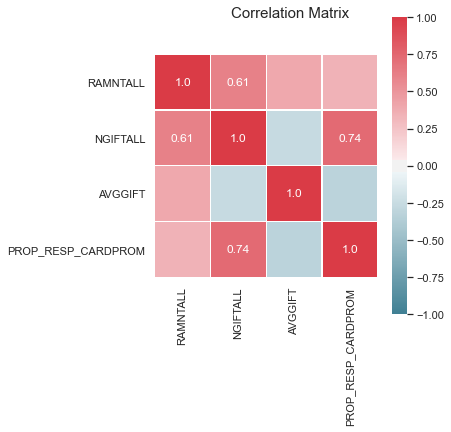

In [57]:
# Prepare figure
fig = plt.figure(figsize=(5, 5))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df_history_file.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=15)

plt.show()

# 4) Neighborhood information - Data from Census

In [58]:
#gets variables corresponding to personal / Demographic Data
df_census = df[list(df.loc[:,'POP901' : 'AC2'])] 

#checks variables
df_census.columns

Index(['POP901', 'POP902', 'POP903', 'POP90C1', 'POP90C2', 'POP90C3',
       'POP90C4', 'POP90C5', 'ETH1', 'ETH2',
       ...
       'HC16', 'HC17', 'HC18', 'HC19', 'HC20', 'HC21', 'MHUC1', 'MHUC2', 'AC1',
       'AC2'],
      dtype='object', length=286)

In [59]:
#DEALING WITH MISSING VALUES
df_census

,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,...,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2
CONTROLN,,,,,,,,,,,,,,,,,,,,,
1,545,165,213,99,0,0,51,49,94,1,...,0,99,0,99,99,97,7,3,5,6
2,1335,372,424,99,0,0,51,49,92,1,...,1,99,0,99,99,98,12,2,6,10
4,1731,414,558,0,99,0,48,52,95,4,...,2,99,0,90,99,98,8,2,7,2
5,4009,1092,1425,0,21,79,50,50,99,0,...,20,47,50,25,98,99,9,2,4,6
7,173,43,87,99,0,0,46,54,94,1,...,0,99,0,99,99,99,8,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191772,30339,8552,12225,93,0,7,47,53,97,0,...,10,94,6,94,99,98,10,3,6,6
191775,720,237,295,60,0,40,48,52,97,1,...,0,98,2,39,99,98,13,3,16,4
191777,1219,277,403,99,0,0,44,56,93,3,...,17,81,11,76,93,99,6,3,7,5


In [60]:
#get metric variables form census
pd.set_option('display.max_columns', None)
df_metrics_census=df_census.select_dtypes(np.number,exclude='bool')

#remove dummies
for col in df_metrics_census.columns:
    if len(df_metrics_census[col].unique()) <=2:
        df_metrics_census.drop(col,inplace=True,axis=1)
        
#Fill median missing variables with median
df_metrics_census=df_metrics_census.apply(lambda x: x.fillna(x.median()),axis=0)

# Get column names first
names = df_metrics_census.columns

# Create the Scaler object
scaler = preprocessing.StandardScaler()

# Fit your data on the scaler object
scaled_df = scaler.fit_transform(df_metrics_census)
scaled_df = pd.DataFrame(scaled_df, columns=names)
  
# Normalizing the Data 
normalized_df = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
df_metrics_census = pd.DataFrame(normalized_df,columns=names) 

# EXPORT DATASET FOR CLUSTER CHARACTERIZATION HERE!

In [344]:
df_characterization = df_personal.join(df_history_file, how='right')
df_characterization = df_characterization.join(df_preferences, how='left') #WATCH OUT FOR THE REMOVED DONORS! LEFT JOIN NECESSARY
df_characterization = df_characterization.join(df_census, how='left')

In [345]:
df_characterization.to_csv('cluster_characterization.csv')


# FEATURE IMPORTANCE

In [61]:
# FEATURE IMPORTANCE

y = df['AVGGIFT'] #target feature 

X = df_metrics_census

# linear regression feature importance

from sklearn.linear_model import LinearRegression

# define the model
model = LinearRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in list((zip(X.columns,importance))):
    if v >=0.1 or v <=(-0.1):
        print('Feature: %s, Score: %.5f' % (i,v))

Feature: POP901, Score: -4.48143
Feature: POP902, Score: 1.12977
Feature: POP903, Score: 6.19301
Feature: POP90C1, Score: 39.89828
Feature: POP90C2, Score: 25.70292
Feature: POP90C3, Score: 34.56870
Feature: POP90C4, Score: 23.60515
Feature: POP90C5, Score: 26.29737
Feature: ETH1, Score: 23.51708
Feature: ETH2, Score: 39.40284
Feature: ETH3, Score: 1.34663
Feature: ETH4, Score: 4.17295
Feature: ETH5, Score: -3.55363
Feature: ETH6, Score: 0.75203
Feature: ETH7, Score: 0.53873
Feature: ETH8, Score: 0.13811
Feature: ETH9, Score: -2.21975
Feature: ETH10, Score: 1.08667
Feature: ETH12, Score: 0.48714
Feature: ETH13, Score: 0.56535
Feature: ETH14, Score: 0.90125
Feature: ETH15, Score: -0.98686
Feature: ETH16, Score: -1.30134
Feature: AGE901, Score: -7.05039
Feature: AGE902, Score: 11.36235
Feature: AGE903, Score: -14.04845
Feature: AGE904, Score: 6.26700
Feature: AGE905, Score: 7.37513
Feature: AGE906, Score: 2.58679
Feature: AGE907, Score: -7.24068
Feature: CHIL1, Score: 7.47279
Feature: CH

In [62]:

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
 


y = df['AVGGIFT'] #target feature 

X = df_metrics_census    
    
def select_features(X_train, y_train, X_test):

# configure to select all features
    fs = SelectKBest(score_func=f_regression, k=72)
# learn relationship from training data
    fs.fit(X_train, y_train)
# transform train input data
    X_train_fs = fs.transform(X_train)
# transform test input data
    X_test_fs = fs.transform(X_test)

    return X_train_fs, X_test_fs, fs


    
#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# what are scores for the features
Metric_Scores=[]

for i,n in list(zip(range(len(fs.scores_)),X.columns)):
    Metric_Scores.append([n,fs.scores_[i]])
    
Best_Scores=pd.DataFrame(Metric_Scores, columns=["Feature", "Score"])
Best_Scores.sort_values(by="Score", ascending=False).head(25)



,Feature,Score
71,HV2,583.380825
70,HV1,564.847063
127,IC5,544.997958
126,IC4,453.425127
145,IC23,447.049515
136,IC14,441.451203
124,IC2,437.561586
102,HVP6,436.656097
98,HVP2,428.309944
125,IC3,428.006902


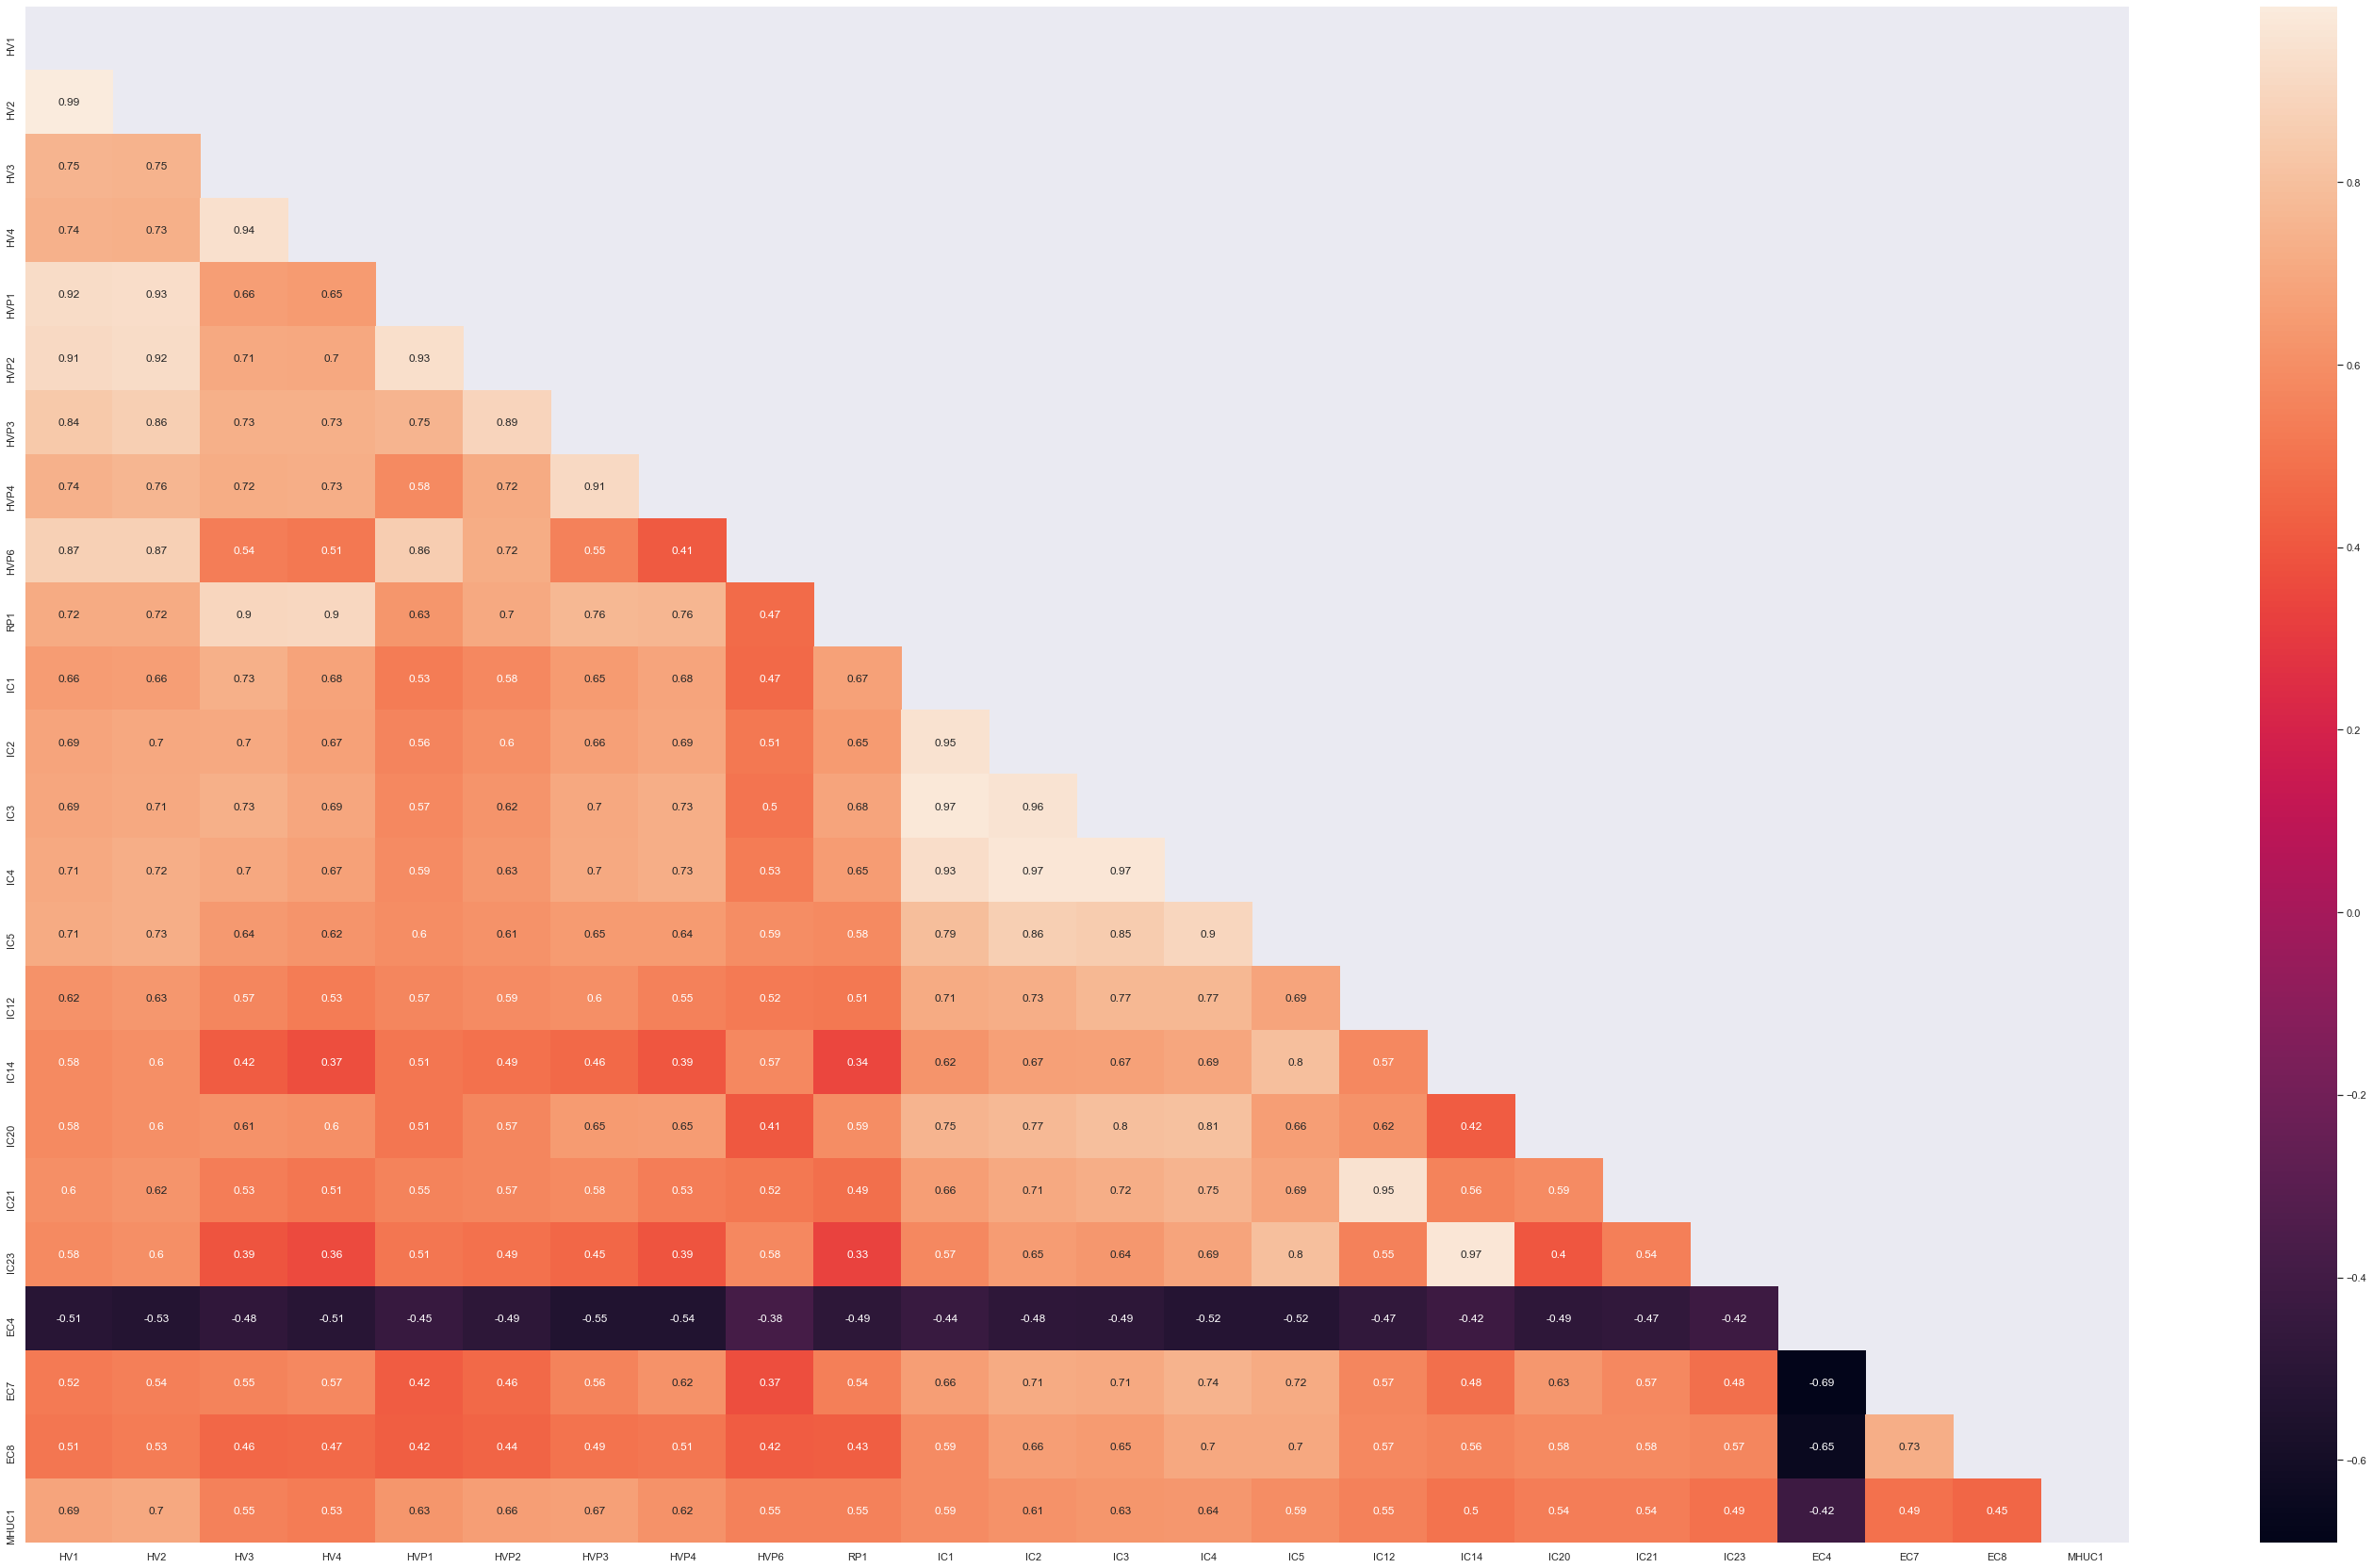

In [63]:
Features_Best_Scores=df_metrics_census[list(Best_Scores.Feature.loc[(Best_Scores.Score>=300)])]

Features_Best_Scores.head()

fig, ax = plt.subplots(figsize=(50, 30))

matrix = np.triu(Features_Best_Scores.corr())
sns.heatmap(Features_Best_Scores.corr(), annot=True, mask=matrix)

In [64]:
Features_Best_Scores.drop(columns=["HV1","HV3","HV4",
                                   "HVP1","HVP2","HVP2","HVP3","HVP6","IC2","IC3","IC4", "IC12","IC14", "IC21"],inplace=True)

In [65]:
'''

- 'HV2'      - Average Home Value in hundredsX
- 'HVP4'     - Percent Home Value >= $75,000X
- #'RP1'      - Percent Renters Paying >= $500 per Month
- #'IC1'      - Median Household Income in hundreds
- 'IC5       - Per Capita IncomeX
- #'IC23      - Percent Families w/ Income >= $150,000
- 'EC4'      - Percent Adults 25+ Completed High School or EquivalencyX
- #'MHUC1',   - Median Homeowner Cost w/ Mortgage per Month dollars

'''

"\n\n- 'HV2'      - Average Home Value in hundredsX\n- 'HVP4'     - Percent Home Value >= $75,000X\n- #'RP1'      - Percent Renters Paying >= $500 per Month\n- #'IC1'      - Median Household Income in hundreds\n- 'IC5       - Per Capita IncomeX\n- #'IC23      - Percent Families w/ Income >= $150,000\n- 'EC4'      - Percent Adults 25+ Completed High School or EquivalencyX\n- #'MHUC1',   - Median Homeowner Cost w/ Mortgage per Month dollars\n\n"

### TARGET NGIFTALL

In [66]:
y = df['NGIFTALL'] #target feature 

X = df_metrics_census



def select_features(X_train, y_train, X_test):

# configure to select all features
    fs = SelectKBest(score_func=f_regression, k=72)
# learn relationship from training data
    fs.fit(X_train, y_train)
# transform train input data
    X_train_fs = fs.transform(X_train)
# transform test input data
    X_test_fs = fs.transform(X_test)

    return X_train_fs, X_test_fs, fs


    
#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# what are scores for the features
Metric_Scores=[]

for i,n in list(zip(range(len(fs.scores_)),X.columns)):
    Metric_Scores.append([n,fs.scores_[i]])
    
Best_Scores=pd.DataFrame(Metric_Scores, columns=["Feature", "Score"])
Best_Scores.sort_values(by="Score", ascending=False).head(25)

,Feature,Score
48,HHAGE3,505.234843
93,ETHC3,502.967920
29,AGE906,484.584615
46,HHAGE1,470.123779
47,HHAGE2,465.940932
40,AGEC7,450.410879
28,AGE905,430.844206
146,HHAS1,424.635342
26,AGE903,406.948234
57,MARR3,395.558704


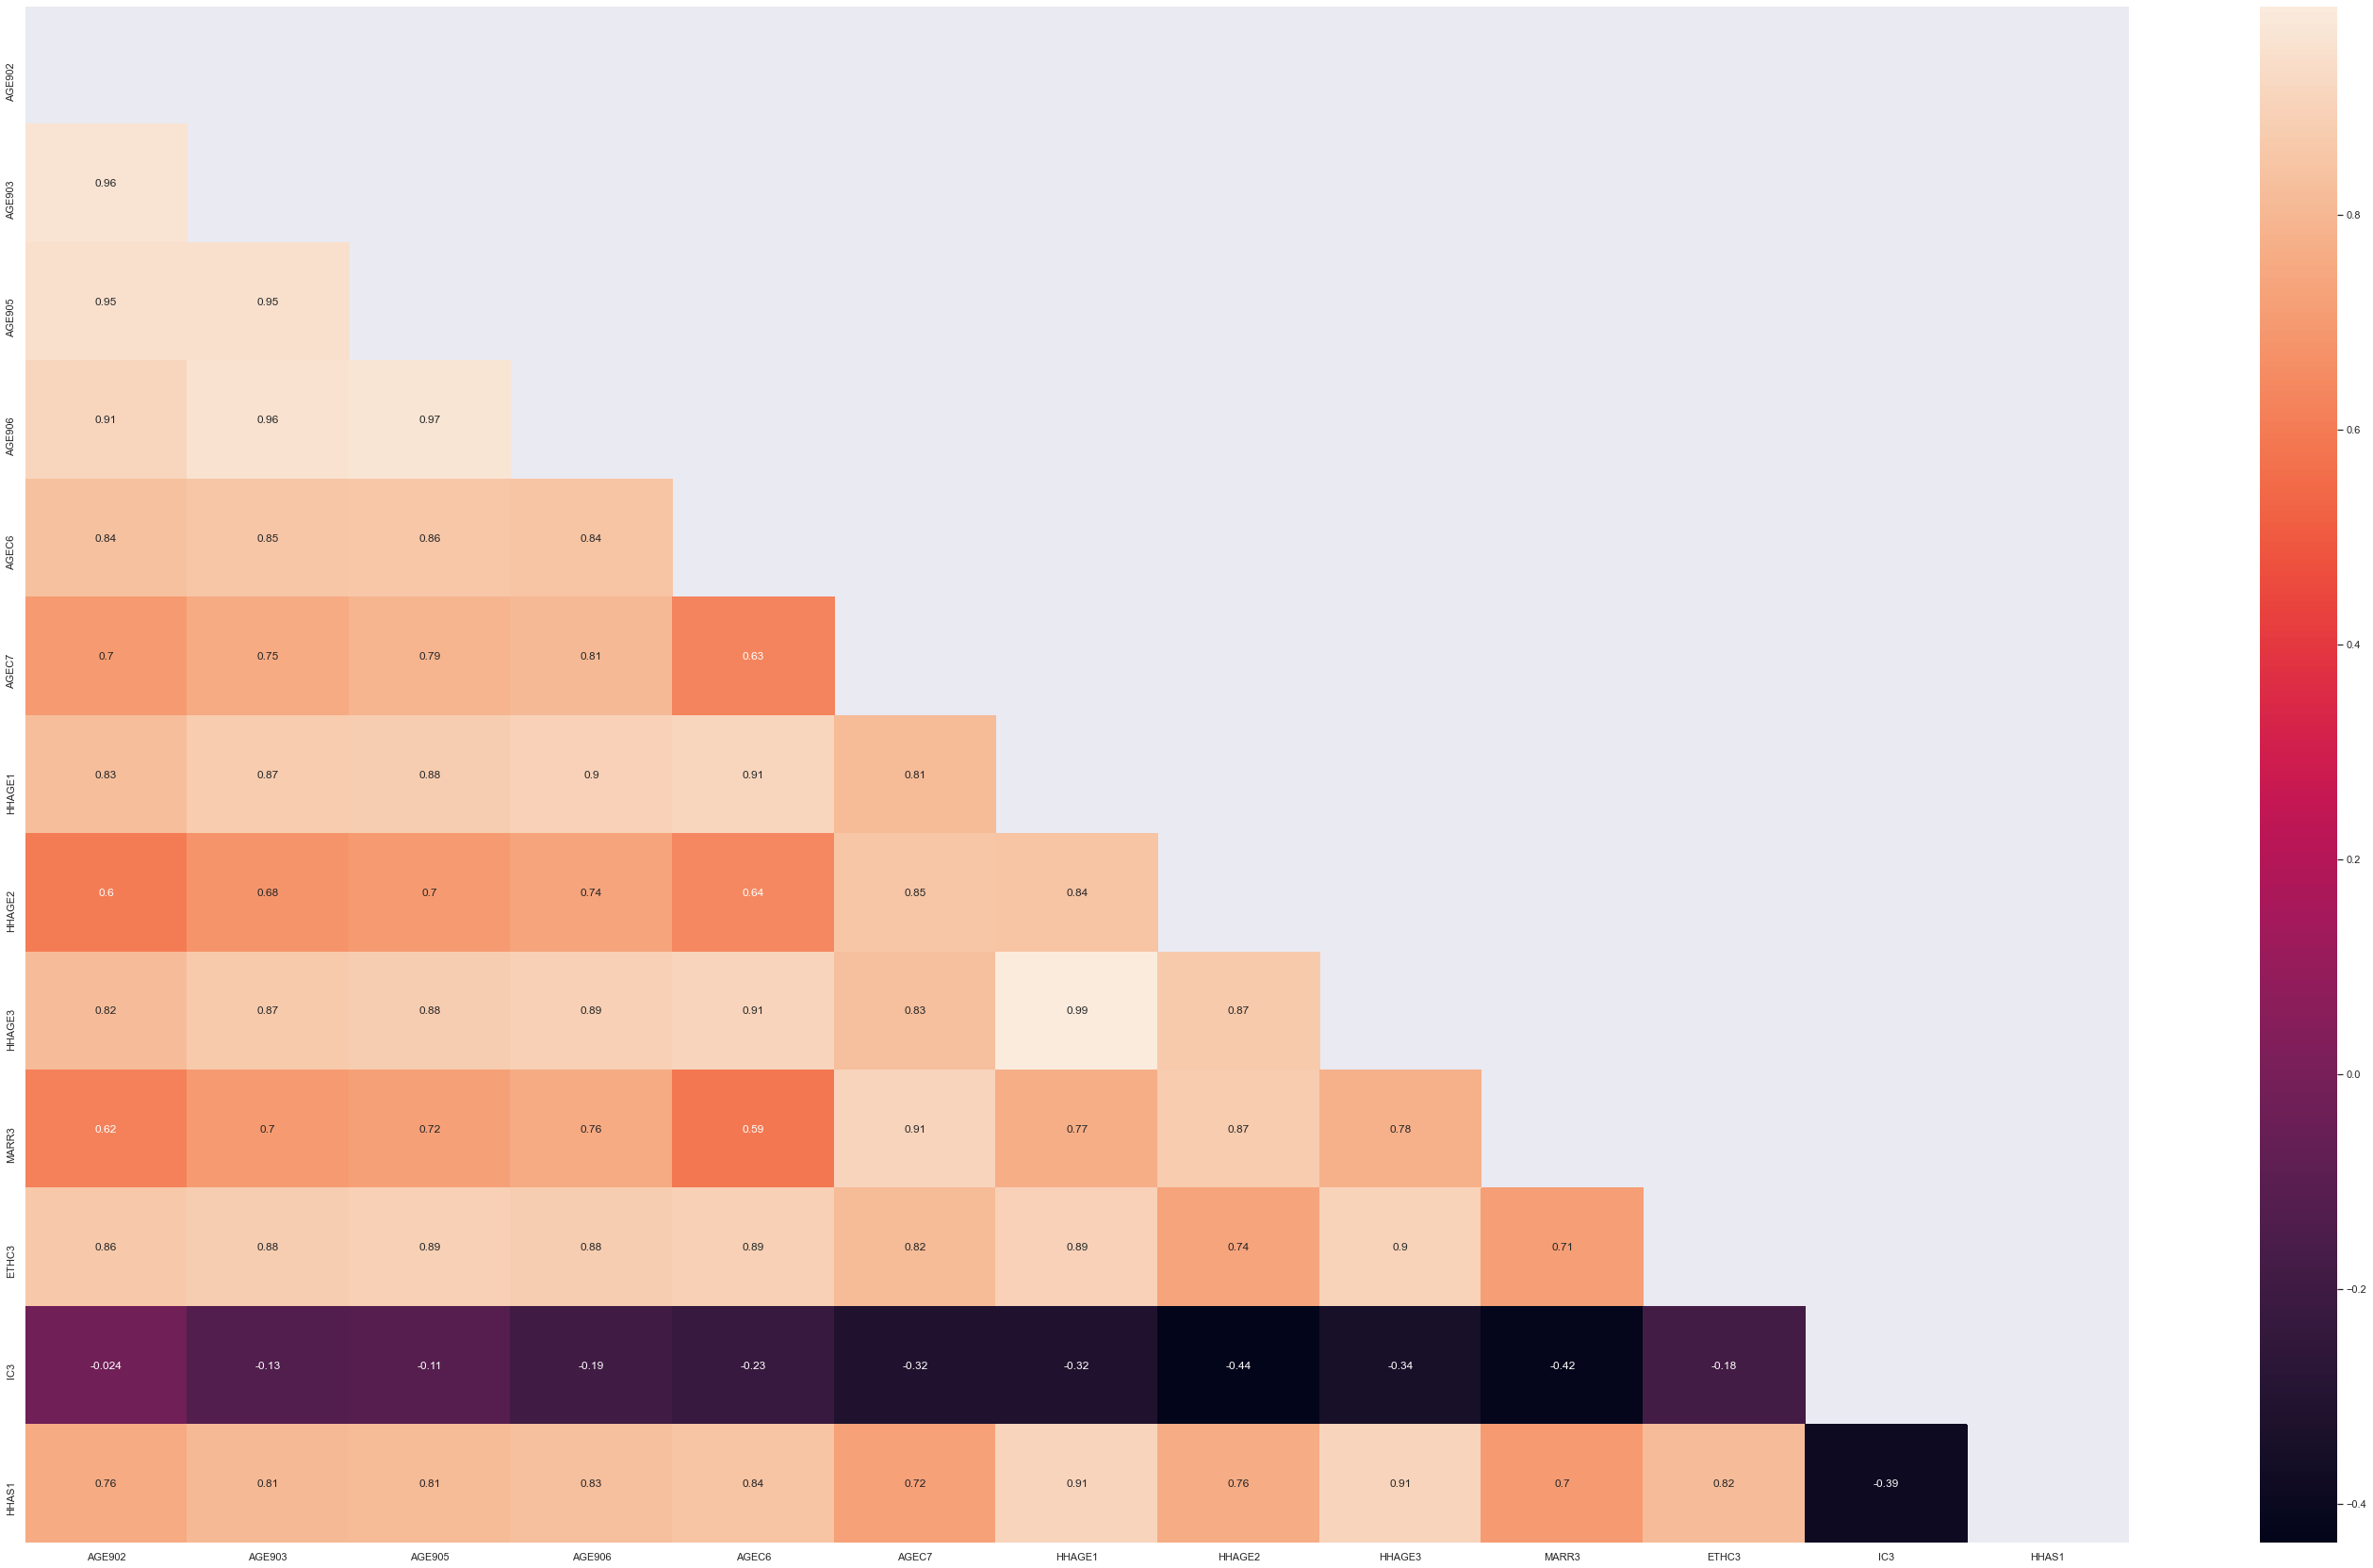

In [67]:
Features_Best_Scores=df_metrics_census[list(Best_Scores.Feature.loc[(Best_Scores.Score>=300)])]

Features_Best_Scores.head()

fig, ax = plt.subplots(figsize=(50, 30))

matrix = np.triu(Features_Best_Scores.corr())
sns.heatmap(Features_Best_Scores.corr(), annot=True, mask=matrix)

In [68]:
'''
HHAGE3X
#MARR3
#IC3

'''

'\nHHAGE3X\n#MARR3\n#IC3\n\n'

In [69]:
df_census = df_census[['HHAGE3','HV2' , 'HVP4', 'IC5', 'EC4', 'ETH1', 'ETH2', 'AGE904', 'MARR2', 'EC1', 'AFC1', 'AFC2', 'AC1', 'AC2']]



# FURTHER DATA CLEANING, EXPLORATION & VISUALIZATION

Associations between personal data and giving/gift history and, alter, the census data will be investigated here:

In [70]:
#start by combining previously CLEANED sub-datasets:
df_processed = df_personal.join(df_history_file, how='right')

In [71]:
df_processed = df_processed.join(df_census, how = 'left')

In [72]:
df_processed.head()


,STATE,ZIP,HOMEOWNR,INCOME,GENDER,WEALTH,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,LONGEVITY,AGE,RAMNTALL,NGIFTALL,AVGGIFT,PROP_RESP_CARDPROM,HHAGE3,HV2,HVP4,IC5,EC4,ETH1,ETH2,AGE904,MARR2,EC1,AFC1,AFC2,AC1,AC2
CONTROLN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,KY,42701,1.0,5.0,0.0,9.0,12,0,0,0,0,0,0,0,89,39.0,209.0,14,14.928571,0.128205,20,937,63,14337,21,95,4,40,7,120,3,7,7,2
8,IL,60435,1.0,5.0,1.0,9.0,0,0,36,31,30,3,3,8,101,49.0,76.0,10,7.600000,0.272727,22,488,4,6596,34,45,48,29,20,120,0,0,2,4
13,TX,75007,1.0,3.0,0.0,9.0,1,0,22,69,5,5,1,2,101,71.0,398.0,44,9.045455,0.394737,2,1130,97,20557,16,91,3,28,7,151,0,0,3,1
15,TX,76006,1.0,5.0,1.0,8.0,0,0,17,43,12,3,1,1,89,64.0,322.0,22,14.636364,0.166667,3,1310,97,22196,19,89,7,31,15,154,0,0,4,1
17,TX,77340,1.0,6.0,1.0,6.0,0,0,0,0,0,0,0,0,101,77.0,144.0,7,20.571429,0.136364,21,582,21,10460,31,71,23,35,19,120,0,0,6,5


In [73]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74288 entries, 4 to 191778
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   STATE               74288 non-null  object 
 1   ZIP                 74288 non-null  object 
 2   HOMEOWNR            74288 non-null  float64
 3   INCOME              74288 non-null  float64
 4   GENDER              74288 non-null  float64
 5   WEALTH              74288 non-null  float64
 6   HIT                 74288 non-null  int64  
 7   MALEMILI            74288 non-null  int64  
 8   MALEVET             74288 non-null  int64  
 9   VIETVETS            74288 non-null  int64  
 10  WWIIVETS            74288 non-null  int64  
 11  LOCALGOV            74288 non-null  int64  
 12  STATEGOV            74288 non-null  int64  
 13  FEDGOV              74288 non-null  int64  
 14  LONGEVITY           74288 non-null  int64  
 15  AGE                 74288 non-null  float64
 16  RAM

Visualize some important variables:

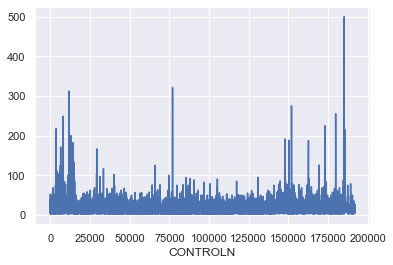

In [74]:
df_processed['AVGGIFT'].plot()

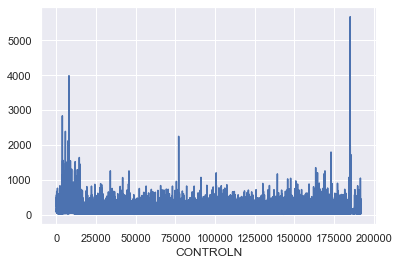

In [75]:
df_processed['RAMNTALL'].plot()

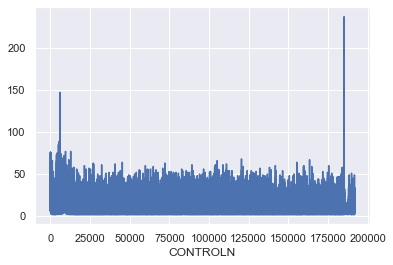

In [76]:
df_processed['NGIFTALL'].plot()

In [77]:
#split between numeric features and categorical/low cardinality features
numeric_variables = list(df_processed.select_dtypes(exclude=['object', 'datetime']).columns)
non_numeric_variables = list(df_processed.select_dtypes(exclude=['float', 'int']).columns)

#removes dummies from numeric_variables and includes them in non_numerical_variables, coz they're categorical even though they're int of float type
dummmy_variables = ['INCOME', 'GENDER', 'WEALTH', 'HOMEOWNR']
numeric_variables = [element for element in numeric_variables if element not in dummmy_variables]
non_numeric_variables.extend(dummmy_variables)

In [78]:
df_processed['AGE'].corr(df_processed['AVGGIFT'])

-0.05052571647570706

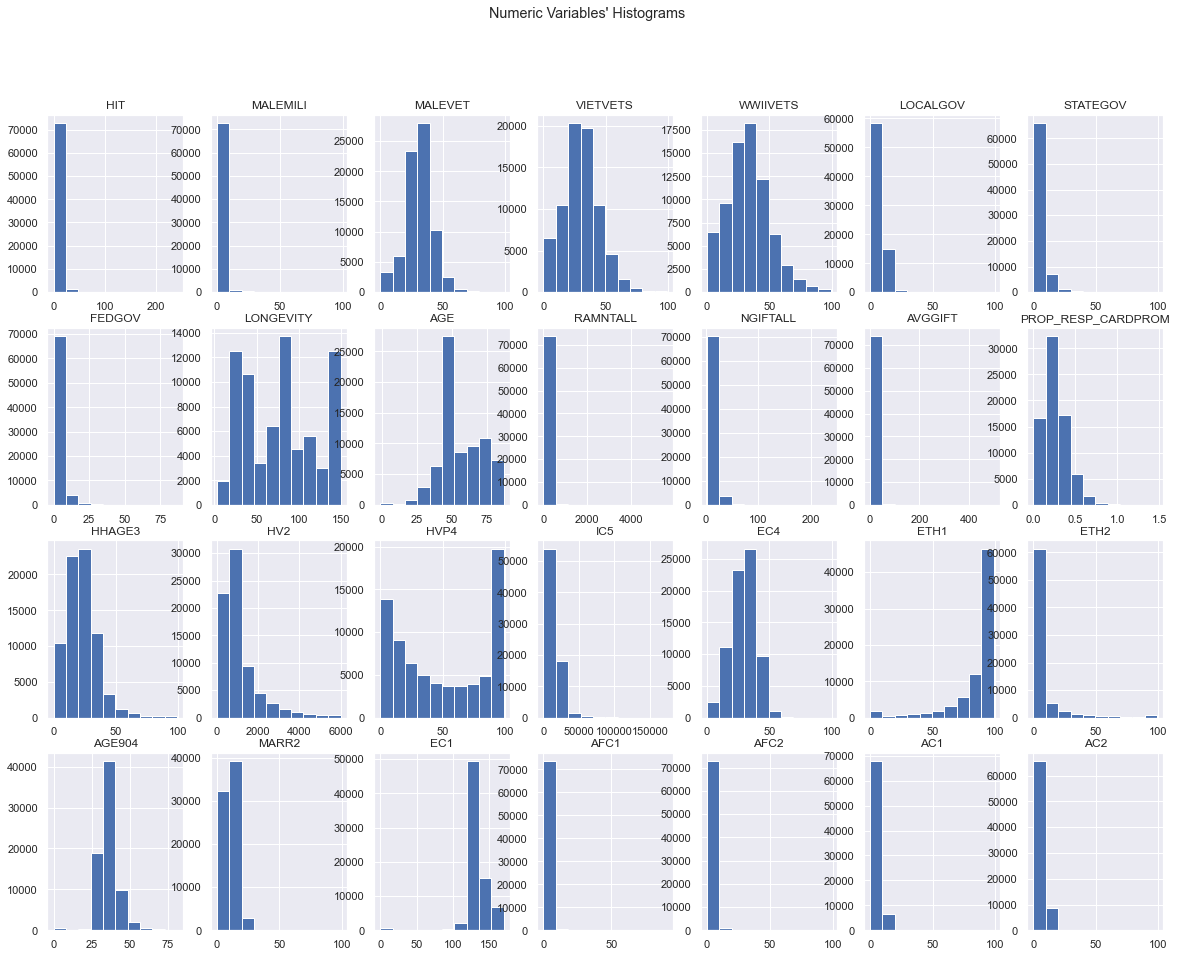

In [79]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(4, ceil(len(numeric_variables) / 4), figsize=(20, 15))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), numeric_variables): # Notice the zip() function and flatten() method
    ax.hist(df_processed[feat])
    ax.set_title(feat)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

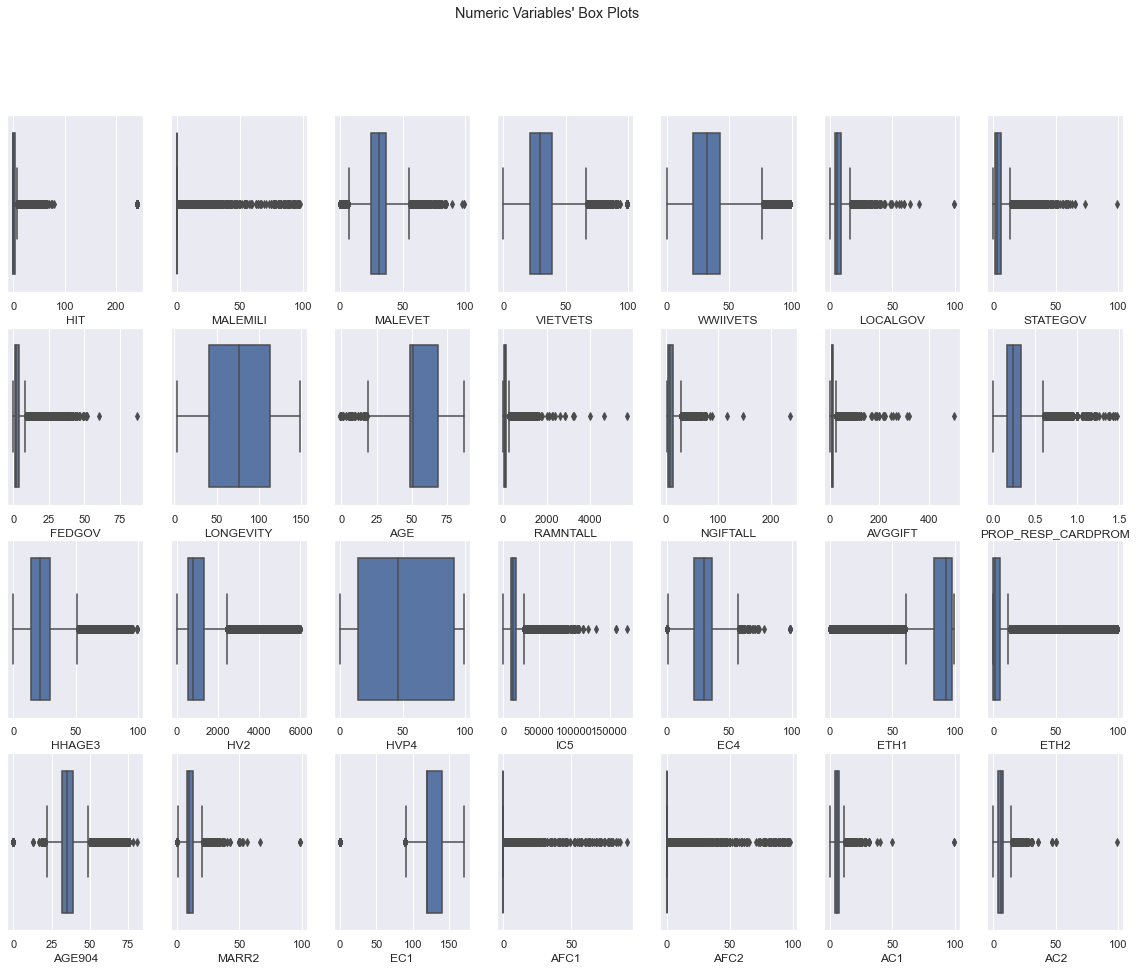

In [80]:
# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(4, ceil(len(numeric_variables) / 4), figsize=(20, 15))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), numeric_variables): # Notice the zip() function and flatten() method
    sns.boxplot(x=df_processed[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

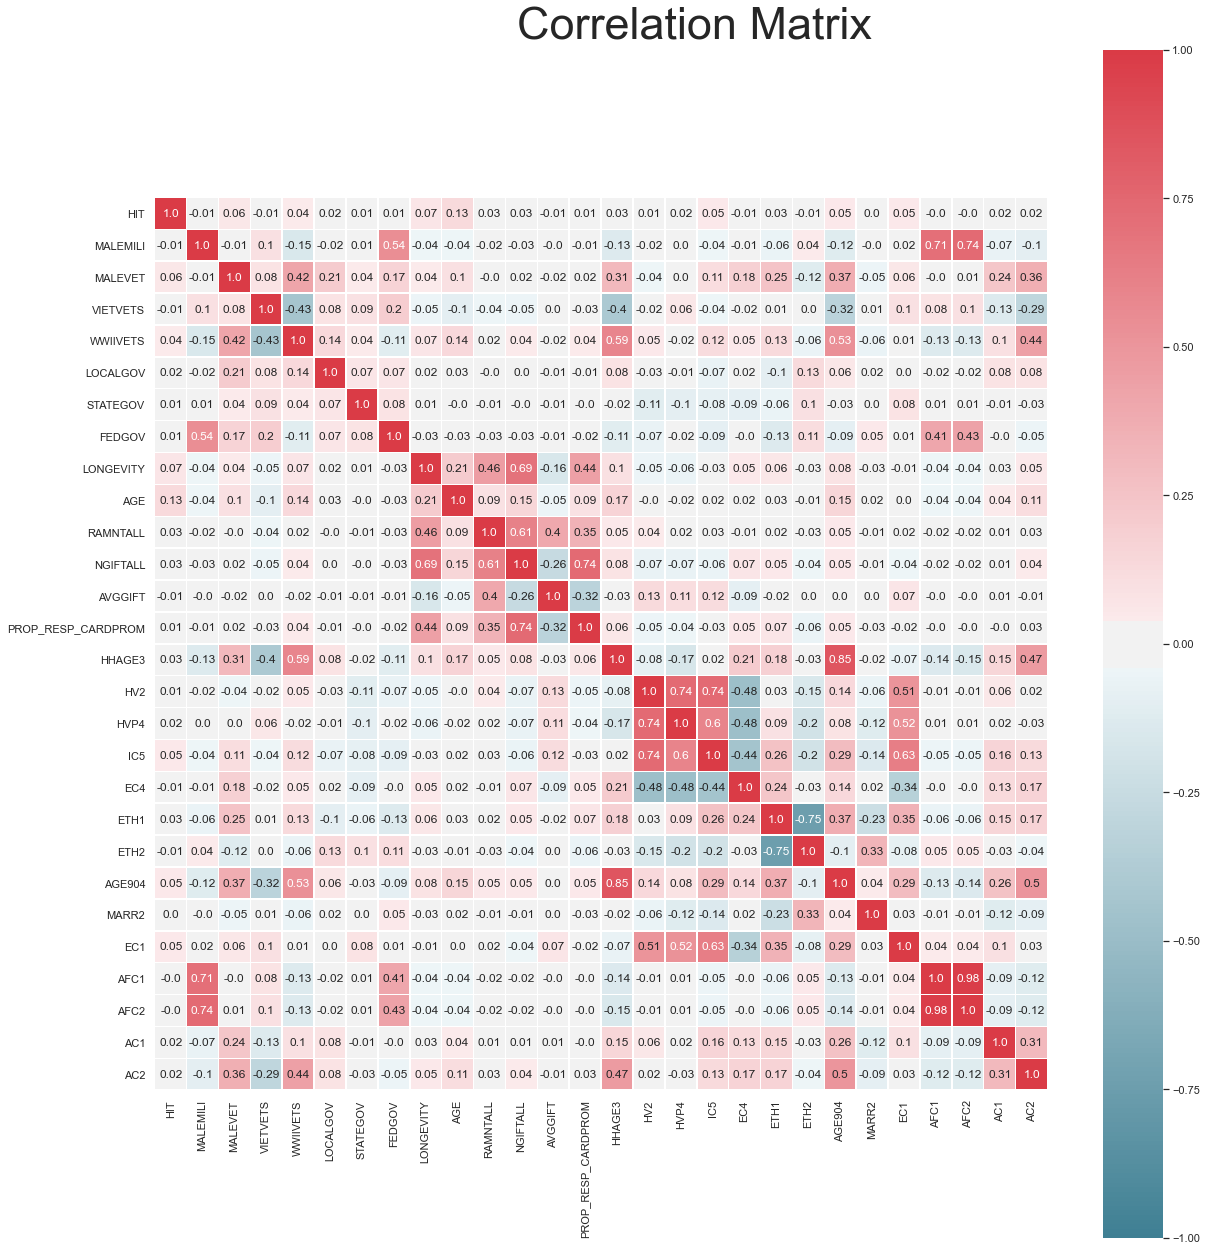

In [81]:
# Prepare figure
fig = plt.figure(figsize=(20, 20))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df_processed[numeric_variables].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=45)

plt.show()

Distribution of donors by age:

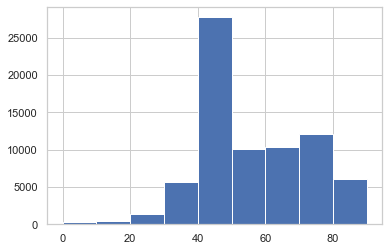

In [82]:
sns.set_style(style="whitegrid")
plt.hist(df_processed.AGE, bins=[0,10,20,30,40,50,60,70,80,90])
plt.show()

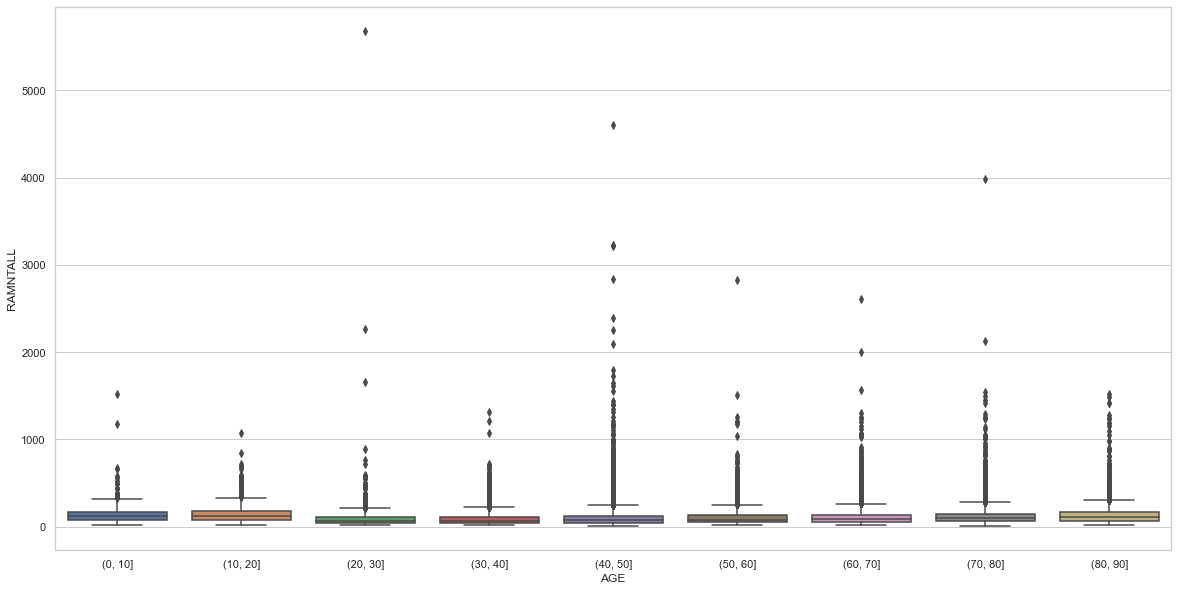

In [83]:
sns.set_style(style="whitegrid")
age_bins = pd.cut(df_processed.AGE, [0,10,20,30,40,50,60,70,80,90])
plt.figure(figsize=(20,10))
sns.boxplot(x = age_bins, y = "RAMNTALL", data=df_processed)
plt.show()

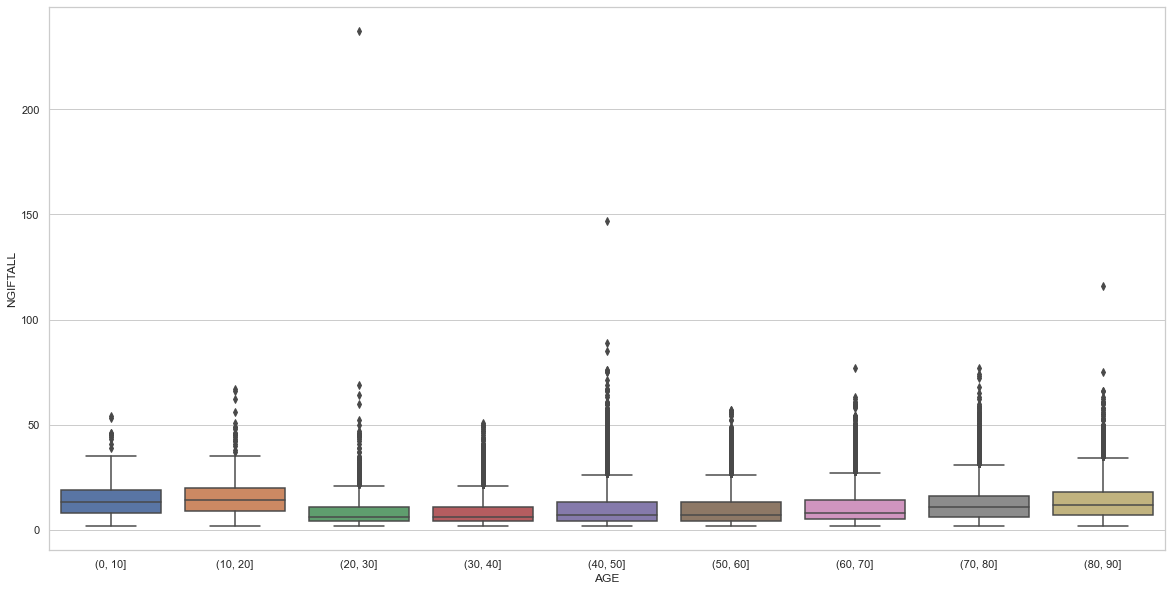

In [84]:
sns.set_style(style="whitegrid")
plt.figure(figsize=(20,10))
sns.boxplot(x = age_bins, y = "NGIFTALL", data=df_processed)
plt.show()

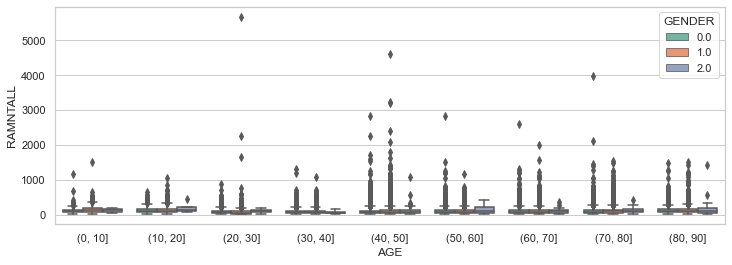

In [85]:
sns.set_style(style="whitegrid")
plt.figure(figsize=(12, 4))
#plt.ylim([0,500]) #remove outliers
sns.boxplot(x = age_bins, y = "RAMNTALL", hue = "GENDER", data=df_processed, palette="Set2")
plt.show()

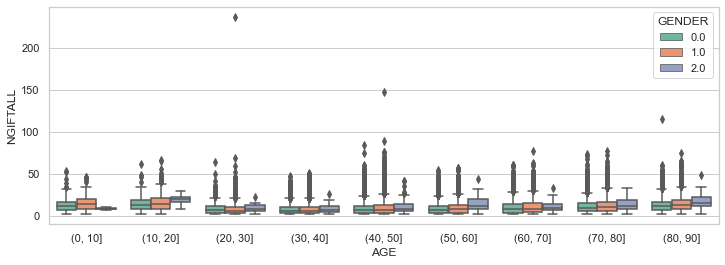

In [86]:
sns.set_style(style="whitegrid")
plt.figure(figsize=(12, 4))
#plt.ylim([0,40])
sns.boxplot(x = age_bins, y = "NGIFTALL", hue = "GENDER", data=df_processed, palette="Set2");

Gender differences by state:

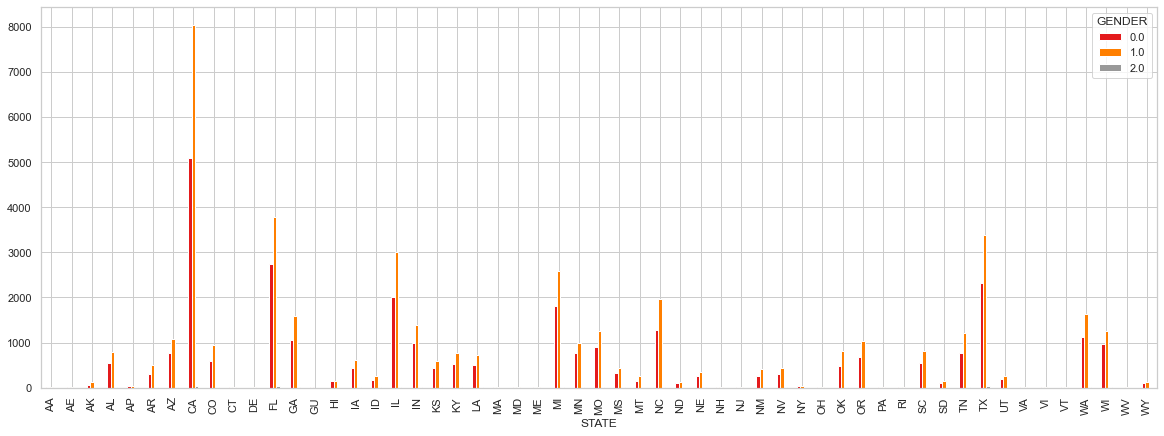

In [87]:
sns.set_style(style="whitegrid")
gender_state=df_processed.groupby(["STATE","GENDER"]).size().reset_index()
gender_state=pd.pivot_table(gender_state,values=0,index="STATE",columns="GENDER")
gender_state.plot(kind="bar", figsize =[20,7], colormap ="Set1")

# DEALING WITH OUTLIERS

In [88]:
df_outlier = df_processed[numeric_variables].copy()

In [89]:
df_outlier.head()

,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,LONGEVITY,AGE,RAMNTALL,NGIFTALL,AVGGIFT,PROP_RESP_CARDPROM,HHAGE3,HV2,HVP4,IC5,EC4,ETH1,ETH2,AGE904,MARR2,EC1,AFC1,AFC2,AC1,AC2
CONTROLN,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,12,0,0,0,0,0,0,0,89,39.0,209.0,14,14.928571,0.128205,20,937,63,14337,21,95,4,40,7,120,3,7,7,2
8,0,0,36,31,30,3,3,8,101,49.0,76.0,10,7.600000,0.272727,22,488,4,6596,34,45,48,29,20,120,0,0,2,4
13,1,0,22,69,5,5,1,2,101,71.0,398.0,44,9.045455,0.394737,2,1130,97,20557,16,91,3,28,7,151,0,0,3,1
15,0,0,17,43,12,3,1,1,89,64.0,322.0,22,14.636364,0.166667,3,1310,97,22196,19,89,7,31,15,154,0,0,4,1
17,0,0,0,0,0,0,0,0,101,77.0,144.0,7,20.571429,0.136364,21,582,21,10460,31,71,23,35,19,120,0,0,6,5


In [90]:
df_outlier.columns

Index(['HIT', 'MALEMILI', 'MALEVET', 'VIETVETS', 'WWIIVETS', 'LOCALGOV',
       'STATEGOV', 'FEDGOV', 'LONGEVITY', 'AGE', 'RAMNTALL', 'NGIFTALL',
       'AVGGIFT', 'PROP_RESP_CARDPROM', 'HHAGE3', 'HV2', 'HVP4', 'IC5', 'EC4',
       'ETH1', 'ETH2', 'AGE904', 'MARR2', 'EC1', 'AFC1', 'AFC2', 'AC1', 'AC2'],
      dtype='object')

In [91]:
#creates new variable "frequency", which indicates the frequency of donations since they're donors (higher frequency, less time between each donation)
#df_outlier['frequency'] = df_outlier['NGIFTALL']/df_outlier['LONGEVITY']

In [92]:
#outlier removal will occur taken these variables in consideration.

#select variables to remove outliers from 
chosen_numerical_variables = df_outlier.loc[:,['RAMNTALL', 'NGIFTALL', 'AVGGIFT', 'LONGEVITY', 'AGE', 'PROP_RESP_CARDPROM']]


In [93]:
#eliminar outliers AVGGIFT:

q25 = chosen_numerical_variables.quantile(.25)
q75 = chosen_numerical_variables.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

#outlier remover function: filter by q + 1,5 * iqr

filtering_df = chosen_numerical_variables[~((chosen_numerical_variables < (q25 - 1.5 * iqr)) |(chosen_numerical_variables > (q75 + 1.5 * iqr))).any(axis=1)]
indices = filtering_df.index.to_list()

df_outlier_removed = df_outlier.loc[indices]

print('Percentage of data kept after removing outliers:', np.round(df_outlier_removed.shape[0] / df_outlier.shape[0]*100, 2))
print('Percentage of data kept from total:', np.round(df_outlier_removed.shape[0] / df.shape[0], 2)*100)

Percentage of data kept after removing outliers: 87.35
Percentage of data kept from total: 68.0


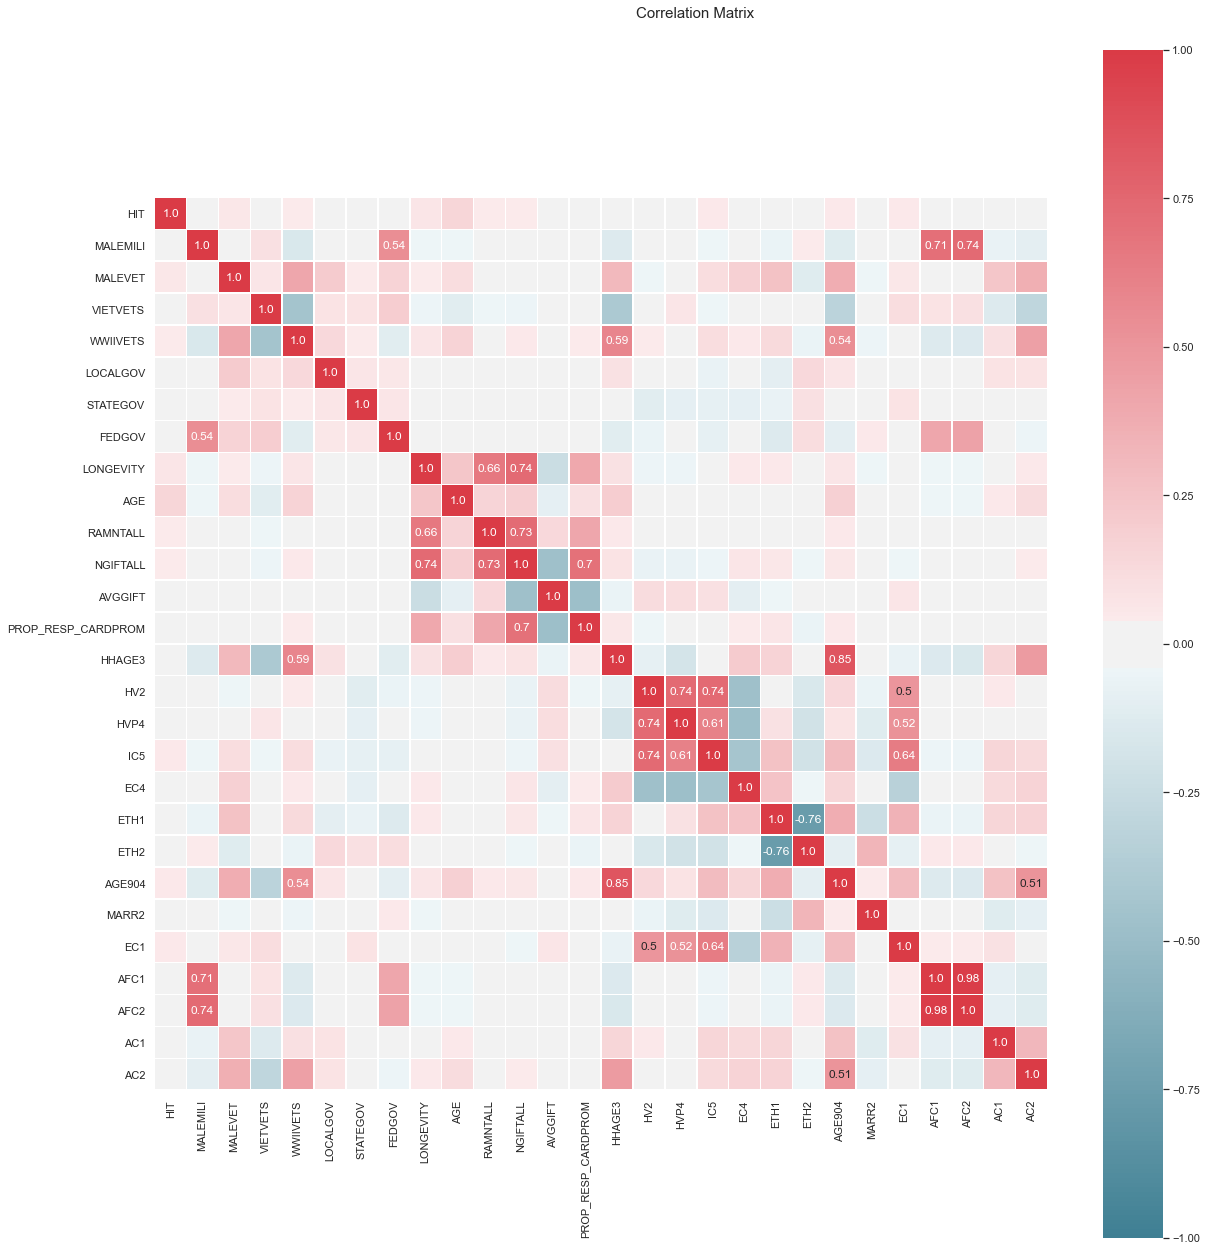

In [94]:
# Prepare figure
fig = plt.figure(figsize=(20, 20))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df_outlier_removed.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=15)

plt.show()

In [95]:
#save data without outliers as csv

df_outlier_removed.to_csv('Outliers_Removed_notstd.csv')

In [96]:
#do same for outliers themselves

remaining_df = chosen_numerical_variables[((chosen_numerical_variables < (q25 - 1.5 * iqr)) |(chosen_numerical_variables > (q75 + 1.5 * iqr))).any(axis=1)]
out_indices = remaining_df.index.to_list()
rem_out = df_outlier.loc[out_indices]

In [97]:
#save as CSV to import on other Datasets

rem_out.to_csv('outliers_notstd.csv')

Next Notebook will continue from here...